## Klasifikacia na 3 hodinovom okne s 15 minutovym predstihom pomocou neuronovych sieti

# Neural networks

In [ ]:
# !pip install torch
# !pip install torch_geometric

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_curve, roc_auc_score, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

from keras import regularizers

# Nacitanie dat

In [2]:
amp_windows_positive = pd.read_csv("amp_windows_positive_3h_prediction.csv", index_col=0)
amp_windows_negative = pd.read_csv("amp_windows_negative_3h_prediction.csv", index_col=0)

def extract_features(row):
    amplitudes = np.array(row)
    return {
        "A_base": amplitudes
    }

amp_windows_positive['A_base'] = amp_windows_positive['A_base'].apply(eval)
features = amp_windows_positive['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_positive['is_eq']], axis=1)

amp_windows_negative['A_base'] = amp_windows_negative['A_base'].apply(eval)
features = amp_windows_negative['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_negative['is_eq']], axis=1)

In [3]:
print(len(amp_windows_positive))
print(len(amp_windows_negative))

511
400


In [4]:
len(amp_windows_positive["A_base"][0])

108000

In [5]:
amp_windows_positive.head(1)

A_base  is_eq
0  [12.304512000000004, 12.380404, 12.387794, 12....      1

# Vypocet fourierovej amplitudy a vykreslenie viacerych grafov

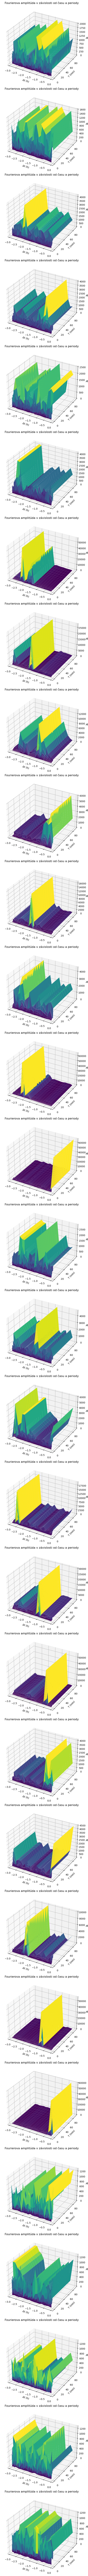

In [64]:
# vypocet frekvencii a fourierovej amplitudy pre zadane okno
def calculate_fft_in_window(signal, sampling_rate):
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    magnitude = np.abs(fft_result)[positive_freq_indices]
    
    return freq, magnitude

# Výpočet amplitúd pre zadané časové periody
def extract_amplitudes_per_period(freq, magnitude, period_range):
    amplitudes = []
    for T in period_range:
        f = 1 / (T * 60)  # frekvencia pre periodu v sekundách
        
        closest_index = np.argmin(np.abs(freq - f))
        amplitudes.append(magnitude[closest_index])
    return amplitudes

# definovanie rozsahu period
def get_period_range(window_size, sampling_rate, num=300):
    T_max = window_size / (2 * sampling_rate * 60)
    T_min = 0.1
    return np.logspace(np.log10(T_min), np.log10(T_max), num=num)

fig, ax = plt.subplots(nrows=30, ncols=1, figsize=(10, 150), subplot_kw={"projection": "3d"})

sampling_rate = 10 # vzorkovacia frekvencia
window_sizes = sampling_rate * 3600 * 3  # 3 hodin v sekundách
step_size = sampling_rate * 60 * 10   # krok okna 10 minút v sekundách

period_ranges = [get_period_range(w, sampling_rate) for w in [window_sizes]][0]

results_list = []
T_list = []
Delta_t_list = []

for idx, df in amp_windows_positive[:30].iterrows():
    time_in_seconds, amplitude = (np.arange(len(df["A_base"])), np.array(df["A_base"]))
    
    time_offsets = []
    results = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_sizes:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results.append(amplitudes)
    
        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size
    
    results = np.array(results)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)

    results_list.append(results)
    T_list.append(T)
    Delta_t_list.append(Delta_t)
    
    ax[idx].plot_surface(Delta_t, T, results, cmap='viridis')
    ax[idx].set_title("Fourierova amplitúda v závislosti od času a periody")
    ax[idx].set_xlabel("\u0394t (h)")
    ax[idx].set_ylabel("T (min)")
    ax[idx].set_zlabel("Af")

plt.tight_layout()
plt.show()

In [216]:
len(T_list[0])

36

# Priprava dat na modelovanie

In [6]:
# vypocet frekvencii a fourierovej amplitudy pre zadane okno
# pozitivne priklady

def calculate_fft_in_window(signal, sampling_rate):
    """Fourierova transformácia v danom časovom okne."""
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    magnitude = np.abs(fft_result)[positive_freq_indices]
    
    return freq, magnitude

# Výpočet amplitúd pre zadané časové periody
def extract_amplitudes_per_period(freq, magnitude, period_range):
    amplitudes = []
    for T in period_range:
        f = 1 / (T * 60)  # frekvencia pre periodu v sekundách !!!!!! zmena zo 60 na 1
        
        closest_index = np.argmin(np.abs(freq - f))
        amplitudes.append(magnitude[closest_index])
    return amplitudes

# definovanie rozsahu period
def get_period_range(window_sz, sampling_rate, num=300):
    T_max = window_sz / (2 * sampling_rate * 60)  # Perióda v minútach
    T_min = 0.1  # Minimálna perióda (6 sekúnd)
    return np.logspace(np.log10(T_min), np.log10(T_max), num=num)


sampling_rate = 10 # vzorkovacia frekvencia
window_size = 3 * 3600 * sampling_rate  # 3 hodin v sekundách
step_size = sampling_rate * 60 * 10   # krok okna 10 minút v sekundách
# period_range = np.linspace(0.01, 10, 100)  # periody od 1 do 5 minút

period_ranges = [get_period_range(w, sampling_rate) for w in [window_size]][0]

results_amp_pos = []
T_list_pos = []
Delta_t_list_pos = []

for amp in list(amp_windows_positive["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)
    T = T / np.max(T)

    results_amp_pos.append(results_amp)
    T_list_pos.append(T)
    Delta_t_list_pos.append(Delta_t)

In [7]:
len(Delta_t_list_pos[0][0])

300

In [8]:
# negativne priklady

results_amp_neg = []
T_list_neg = []
Delta_t_list_neg = []

for amp in list(amp_windows_negative["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)
    T = T / np.max(T)

    results_amp_neg.append(results_amp)
    T_list_neg.append(T)
    Delta_t_list_neg.append(Delta_t)

In [9]:
len(T_list_neg[0][0])

300

In [10]:
# vytvorenie dataframov s pozitivnymi a negativnymi prikladmi
amp_windows_positive_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_pos,
        "T": T_list_pos,
        "Delta_t": Delta_t_list_pos,
        "is_eq": 1
    }
)

amp_windows_negative_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_neg,
        "T": T_list_neg,
        "Delta_t": Delta_t_list_neg,
        "is_eq": 0
    }
)

# Modelovnaie

In [12]:
len(amp_windows_negative_fourier)

400

In [29]:
amp_windows_positive_sample = amp_windows_positive_fourier.sample(400)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(400)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

Epoch 1/40


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 895ms/step - accuracy: 0.5009 - loss: 2.0892 - val_accuracy: 0.4792 - val_loss: 0.6931
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 880ms/step - accuracy: 0.4787 - loss: 0.7253 - val_accuracy: 0.5104 - val_loss: 0.6931
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 882ms/step - accuracy: 0.5175 - loss: 0.6896 - val_accuracy: 0.5312 - val_loss: 0.6931
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 884ms/step - accuracy: 0.5567 - loss: 0.6860 - val_accuracy: 0.5729 - val_loss: 0.6928
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 867ms/step - accuracy: 0.5471 - loss: 0.6934 - val_accuracy: 0.5521 - val_loss: 0.6928
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 868ms/step - accuracy: 0.6144 - loss: 0.6675 - val_accuracy: 0.5417 - val_loss: 0.6929
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 875ms/step - accuracy: 0.5743 - loss: 0.6742 - val_accuracy: 0.6042 - val_loss: 0.6923
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 874ms/step - accuracy: 0.5819 - loss: 0.6629 - val_accuracy: 0.625

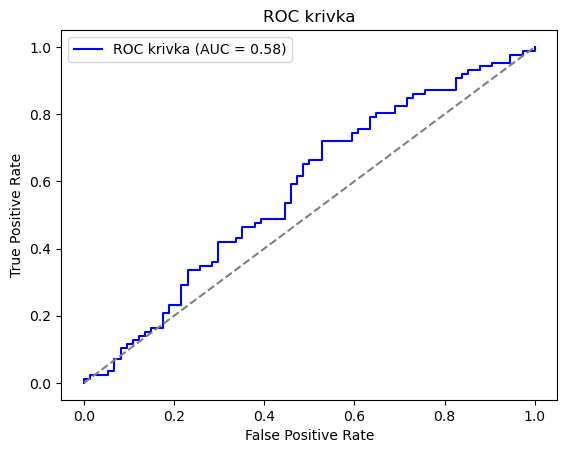

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.41      0.47        74
           1       0.58      0.72      0.65        86

    accuracy                           0.57       160
   macro avg       0.57      0.56      0.56       160
weighted avg       0.57      0.57      0.56       160



In [34]:
# modelovnaie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=40, 
    batch_size=32, 
    validation_split=0.15,
    callbacks=[early_stopping]
)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# ROC krivka
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC krivka (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivka")
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

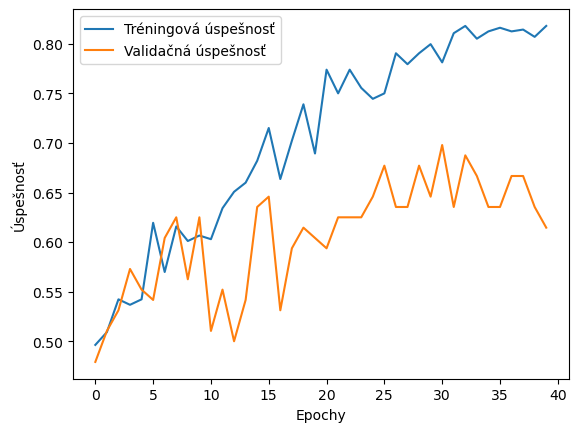

In [35]:
# priebeh ucenia sa modelu v priebehu epoch
plt.plot(history.history['accuracy'], label='Tréningová úspešnosť')
plt.plot(history.history['val_accuracy'], label='Validačná úspešnosť')
plt.xlabel('Epochy')
plt.ylabel('Úspešnosť')
plt.legend()
plt.show()

In [36]:
# ulozenie modelu
with open("models/nn_conv_3h.pkl", "wb") as f:
    pickle.dump(model, f)

## MLP

In [11]:
amp_windows_positive_sample = amp_windows_positive_fourier.sample(400)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(400)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

# scaler = MinMaxScaler(feature_range=(0, 0.5))

# X = np.array([
#     np.concatenate([
#         scaler.fit_transform(np.array(seq).reshape(-1, 1)).flatten() if isinstance(seq, (list, np.ndarray)) else [seq]
#         for seq in row
#     ])
#     for row in data[["A_base_fourier", "T"]].values
# ])

# X = scaler.fit_transform(X)

Epoch 1/90


/opt/conda/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5576 - loss: 0.9198 - val_accuracy: 0.5312 - val_loss: 2.1979
Epoch 2/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5636 - loss: 0.8409 - val_accuracy: 0.5312 - val_loss: 1.8699
Epoch 3/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6004 - loss: 0.7778 - val_accuracy: 0.5312 - val_loss: 1.4546
Epoch 4/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6327 - loss: 0.7557 - val_accuracy: 0.5312 - val_loss: 0.9479
Epoch 5/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5883 - loss: 0.8462 - val_accuracy: 0.4792 - val_loss: 0.9068
Epoch 6/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5466 - loss: 0.8109 - val_accuracy: 0.5000 - val_loss: 0.7831
Epoch 7/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5934 - loss: 0.7332 - val_accuracy: 0.5417 - val_loss: 0.7284
Epoch 8/90
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6242 - loss: 0.7098 - val_accuracy: 0.5417 - val_loss: 0.

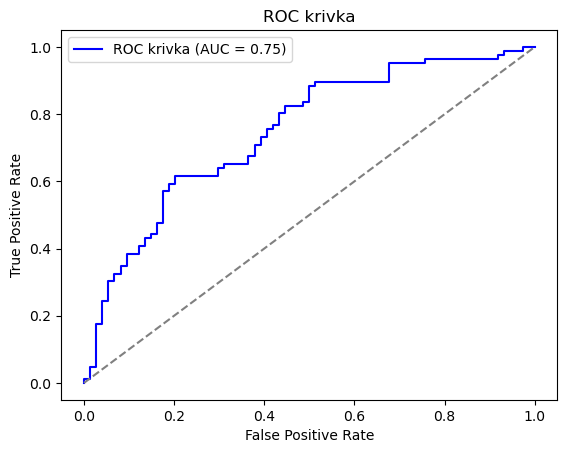

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        74
           1       0.68      0.73      0.71        86

    accuracy                           0.68       160
   macro avg       0.67      0.67      0.67       160
weighted avg       0.67      0.68      0.67       160



In [16]:
# modelovnaie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential([
    Flatten(input_shape=(X.shape[1], 1)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_split=0.15,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Testovacia presnosť: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# ROC krivka
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC krivka (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivka")
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

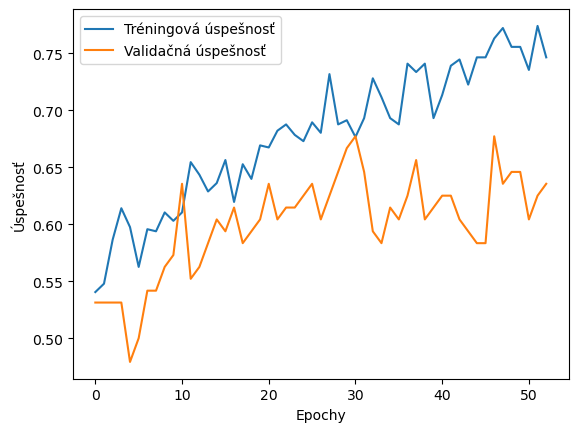

In [17]:
# priebeh ucenia sa modelu v priebehu epoch
plt.plot(history.history['accuracy'], label='Tréningová úspešnosť')
plt.plot(history.history['val_accuracy'], label='Validačná úspešnosť')
plt.xlabel('Epochy')
plt.ylabel('Úspešnosť')
plt.legend()
plt.show()

In [20]:
# ulozenie modelu
with open("models/nn_mlp_3h.pkl", "wb") as f:
    pickle.dump(model, f)